In [2]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from utils3 import *
import pickle
import pandas as pd
import json
import networkx as nx
from tqdm.notebook import tqdm
import time
import gymnasium as gym
from gymnasium import spaces
import subprocess
import multiprocessing
import concurrent.futures
import os
import random
from collections import defaultdict

In [3]:
input_signals_list_small_molecules = [
    {0: 0.0278, 1: 0.0022, 2: 0.0042},  # First set of input signals
    {0: 0.0278, 1: 0.0022, 2: 2.0082},  # Second set of input signals
    {0: 0.0278, 1: 5.0543, 2: 0.0042},  # Third set of input signals
    {0: 0.0278, 1: 5.0543, 2: 2.0082},  # First set of input signals
    {0: 3.9239, 1: 0.0022, 2: 0.0042},  # Second set of input signals
    {0: 3.9239, 1: 0.0022, 2: 2.0082},  # Third set of input signals    
    {0: 3.9239, 1: 5.0543, 2: 0.0042},  # Second set of input signals
    {0: 3.9239, 1: 5.0543, 2: 2.0082},  # Third set of input signals  
]    



input_signals_list_binary = [
    {0: 0, 1: 0, 2: 0},  # First set of input signals
    {0: 0, 1: 0, 2: 1},  # Second set of input signals
    {0: 0, 1: 1, 2: 0},  # Third set of input signals
    {0: 0, 1: 1, 2: 1},  # First set of input signals
    {0: 1, 1: 0, 2: 0},  # Second set of input signals
    {0: 1, 1: 0, 2: 1},  # Third set of input signals    
    {0: 1, 1: 1, 2: 0},  # Second set of input signals
    {0: 1, 1: 1, 2: 1},  # Third set of input signals  
]   


# ## Postech's library characterization

# %%


# Data
repressor_data = {
    "Repressor": ["AmeR", "AmtR", "BetI", "BM3R1", "BM3R1", "BM3R1", "HlyIIR", "IcaRA", "LitR", "LmrA", 
                  "PhlF", "PhlF", "PhlF", "PsrA", "QacR", "QacR", "SrpR", "SrpR", "SrpR", "SrpR"],
    "RBS": ["F1", "A1", "E1", "B1", "B2", "B3", "H1", "I1", "L1", "N1", 
            "P1", "P2", "P3", "R1", "Q1", "Q2", "S1", "S2", "S3", "S4"],
    "ymaxa": [3.835, 5.036, 3.065, 0.543, 0.822, 0.704, 2.462, 3.558, 4.296, 2.152,
              3.901, 6.505, 6.794, 6.489, 3.744, 3.778, 1.216, 2.556, 2.547, 3.314],
    "ymina": [1.06, 0.091, 1e-14, 0.002, 1e-14, 1e-14, 0.057, 1e-14, 0.074, 0.183,
              0.01, 1e-14, 1e-14, 1e-14, 1e-14, 1e-14, 1e-14, 1e-14, 1e-14, 1e-14],
    "Ka": [0.122, 0.022, 0.363, 0.051, 0.285, 0.261, 1e-14, 0.186, 1e-14, 1e-14,
          1e-14, 0.16, 0.167, 0.305, 0.126, 0.456, 1e-14, 0.224, 0.4, 0.108],
    "n": [1.306, 1.308, 1.833, 2.042, 1.685, 1.768, 2.596, 1.085, 1.696, 2.095,
          4, 2.237, 2.01, 1.54, 1.706, 1.979, 1.66, 1.337, 1.569, 1.344],
    "Toxicity (RPU)": ["-", "-", "-", "-", "-", "-", 4.06525, 0.47094, "-", "-", 
                       "-", "-", "-", "-", 4.06525, "-", "-", "-", "-", "-"]
}

# Create DataFrame
cello_v1_hill_function_parameters = pd.DataFrame(repressor_data)

cello_v1_hill_function_parameters


# ## Postech's toxicity data

# %%


# Load the JSON file
file_path = '/home/gridsan/spalacios/DRL1/supercloud-testing/ABC-and-PPO-testing1/gate_toxicity_POSTECH.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract all gate toxicity data
gate_toxicity_data = [item for item in data if item.get("collection") == "gate_toxicity"]

# Convert the list of dictionaries into a DataFrame
gate_toxicity_df = pd.DataFrame(gate_toxicity_data)

gate_toxicity_df.head()


,collection,gate_name,input,growth
0,gate_toxicity,F1_AmeR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.936601827, 0.929528441, 0.927586207, 0.9..."
1,gate_toxicity,A1_AmtR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.005567327, 0.987403446, 1.01189251, 1.01..."
2,gate_toxicity,E1_BetI,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.465830721, 1.017868339, 1.023301985, 1.0..."
3,gate_toxicity,B1_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.992753623, 0.971014493, 0.992914654, 0.9..."
4,gate_toxicity,B2_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.978445044, 1.001274554, 1.019855551, 0.9..."


In [4]:
with open('output_run_postech_1_graphs.pkl', 'rb') as f:
    output_run_postech_1_graphs = pickle.load(f)


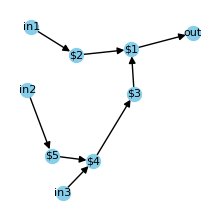

Nodes and their attributes:
Node $1:
Node out:
Node $2:
Node $3:
Node $4:
Node in1:
Node in3:
Node $5:
Node in2:


In [5]:
hex_string = "0x02"

G = output_run_postech_1_graphs[hex_string]

plt.figure(figsize=(2, 2))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
        edge_color='k', linewidths=1, font_size=8, 
        arrows=True, arrowsize=10)
plt.show()  

for node in G.nodes:
    G.nodes[node].clear()

# Step 3: Remove all edge attributes
for u, v in G.edges:
    G.edges[u, v].clear()


# Step 2: Print Node Attributes
print("Nodes and their attributes:")
for node, data in G.nodes(data=True):
    print(f"Node {node}:")
    for attr, value in data.items():
        print(f"  {attr}: {value}")

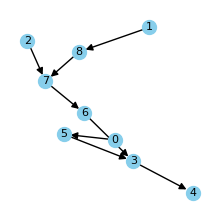

{3: [4], 4: [], 5: [3], 6: [3], 7: [6], 0: [5], 2: [7], 8: [7], 1: [8]}

In [6]:
relabel_mapping = {
    "in1": 0,
    "in2": 1,
    "in3": 2
}

# Starting index for the rest of the nodes
next_label = 3

# Iterate over all nodes and assign labels to those not in the initial mapping
for node in G.nodes:
    if node not in relabel_mapping:
        relabel_mapping[node] = next_label
        next_label += 1

# Step 3: Relabel the nodes
G = nx.relabel_nodes(G, relabel_mapping)

plt.figure(figsize=(2, 2))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
        edge_color='k', linewidths=1, font_size=8, 
        arrows=True, arrowsize=10)
plt.show()  

G_cello = G
# Print the adjacency list to verify the relabeling
adj_list = {node: list(G.successors(node)) for node in G.nodes}
adj_list

[[0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]]
Original graph


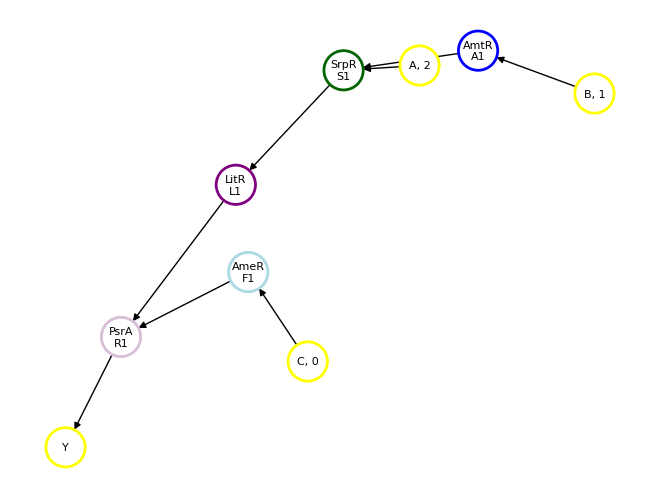

In [7]:
# Determine the size of the matrix
adjacency_list = adj_list

n = max(adjacency_list.keys()) + 1

# Initialize the adjacency matrix with zeros
adjacency_matrix = np.zeros((n, n), dtype=int)

# Fill the adjacency matrix based on the adjacency list
for node, neighbors in adjacency_list.items():
    for neighbor in neighbors:
        adjacency_matrix[node, neighbor] = 1

# Print the adjacency matrix
print(adjacency_matrix)


adj_matrix = adjacency_matrix
random_solution = random_part_selection(cello_v1_hill_function_parameters, n-4)
G_original = assign_representations_with_io_nodes_3(adj_matrix, cello_v1_hill_function_parameters, random_solution) 
print("Original graph")
draw_network_with_colors_and_labels_from_G(G_original)

In [8]:
L_SEED = 21
D_GROWTH_THRESHOLD = 0.75

MAXTEMP = 100.0
MINTEMP = 0.001
STEPS = 600
#Math.log10(MAXTEMP)
#Math.log10(MINTEMP)
#LOGINC = (LOGMAX - LOGMIN) / STEPS
T0_STEPS = 100

In [9]:
initial_solution = random_part_selection(cello_v1_hill_function_parameters, 5)

In [10]:
initial_solution

[7, 6, 9, 5, 16]

Optimizing: 100%|██████████| 700/700 [00:04<00:00, 145.63it/s]


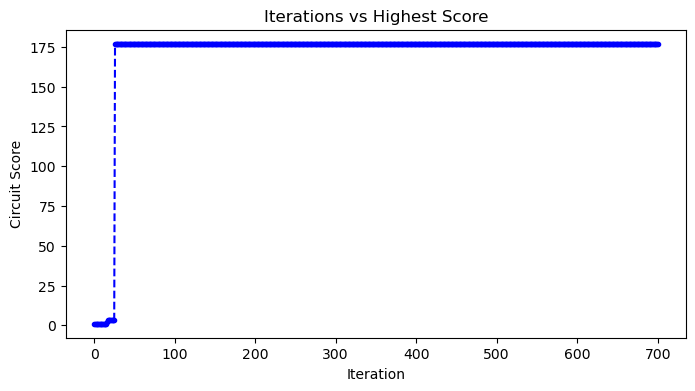

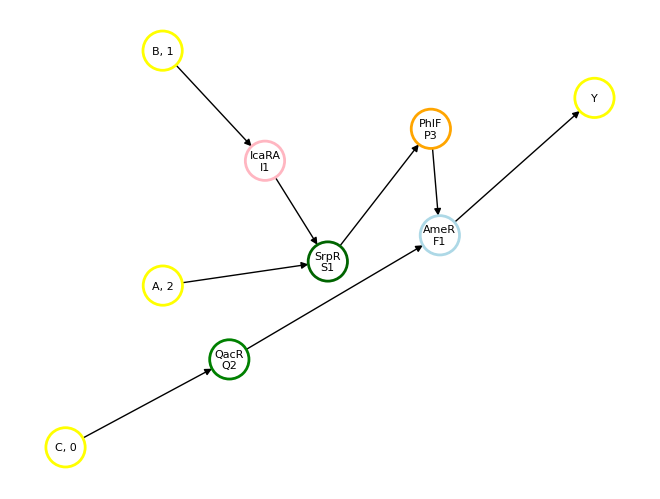

optimal_assignment:  [3, 12, 15, 13, 2]


(177.02051779360593, [3, 12, 15, 13, 2])

In [11]:
simulated_annealing_cello_v3(cello_v1_hill_function_parameters, adj_matrix, initial_solution, MAXTEMP, MINTEMP, STEPS, input_signals_list_small_molecules, input_signals_list_binary, iterations_at_Tmin=T0_STEPS)